# Outdoor path finding from a map and a list of obstacles

Author : Anass El Yaagoubi

- Image Binarization
- Add obstacles (artificial but could be loaded from ground truth)
- Voronoï Diagram
- Apply a path finding algorithm on the graph

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import random
import networkx as nx
random.seed(111)

### Loading the map

In [2]:
img_ = Image.open('../../outdoorMap.png')
img  = np.array(img_)

myMap = np.zeros(img.shape)
myMap[img == (217, 208, 201, 255)] = 1
myMap = myMap[:, :, 0]

###  Visualization

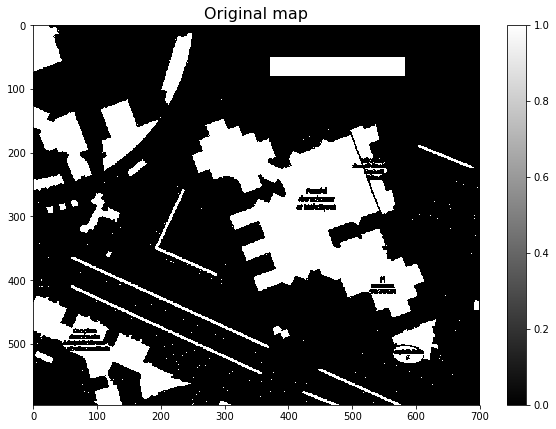

In [3]:
plt.figure(figsize=(10, 10))
plt.title('Original map', fontsize=16)
plt.imshow(myMap, cmap='gray')
plt.colorbar(shrink=0.7)
plt.show()

### Defining auxilary functions :

In [4]:
def distance(point1, point2):
    return (point1[1] - point2[1])**2 + (point1[0] - point2[0])**2


def isValid(points, point):
    for i, j in points:
        if distance((i,j), point) < 100:
            return False
    return True


def getPoints(nbPoints=100):
    points = []
    height, width = myMap.shape
    while len(points) < nbPoints:
        while True: 
            i, j = random.randint(0, height - 1), random.randint(0, width - 1)
            if myMap[i, j] != 1 and isValid(points, (i, j)):
                break
        points.append((i, j))
    return points


def getAssociationMap(img, points):
    associationMap = np.zeros(img.shape)
    for i in range(myMap.shape[0]): #for i in range(myMap[0]):
        for j in range(myMap.shape[1]):
#            if img[i, j] == 1:
#                associationMap[i, j] = 0                
#            else:
                distances = np.array(list(map(lambda x : distance((i, j), x), points)))
                associationMap[i, j] = np.argmin(distances) # 1 + np.argmin(distances)
    return associationMap


def getNeighbors(i, j):
    neighbors = [(i, j)]
    if i > 0 : neighbors.append((i - 1, j))
    if j > 0 : neighbors.append((i, j - 1))
    if j > 0 and i > 0 : neighbors.append((i - 1, j - 1))
    return neighbors

def getGraphNodes(associationMap):
    for i in range(associationMap.shape[0]): #for i in range(myMap[0]):
        for j in range(associationMap.shape[1]):
            neighbors = getNeighbors(i, j)
            classes = set()
            for neighbor in neighbors:
                classes.add(associationMap[neighbor])
            if len(classes) >= 3:
                yield ((i, j), classes)


### Generating the well spaced obstacles

In [5]:
points = getPoints(450)

### Visualization

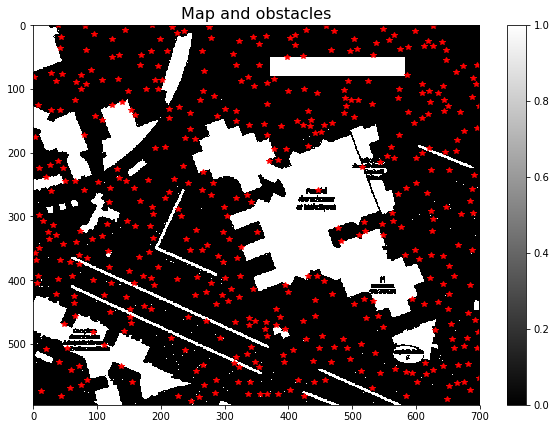

In [6]:
plt.figure(figsize=(10, 10))
plt.title('Map and obstacles', fontsize=16)
plt.imshow(myMap, cmap='gray')
plt.colorbar(shrink=0.7)
for i, j in points:
    plt.plot(j, i, 'r*')    
plt.savefig('mapAndObstacles.png')
plt.show()

### Computing the Voronoi grid (this may take a while)
- TODO : Add parallelization

In [7]:
associationMap = getAssociationMap(myMap, points)

### Visualization

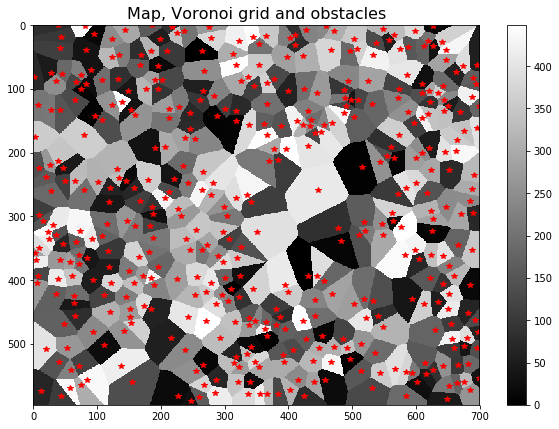

In [8]:
plt.figure(figsize=(10, 10))
plt.title('Map, Voronoi grid and obstacles', fontsize=16)
for i, j in points:
    plt.plot(j, i, 'r*')    
plt.imshow(associationMap, cmap='gray')
plt.colorbar(shrink=0.7)
plt.savefig('mapVoronoiAndObstacles.png')
plt.show()

### Getting the nodes of the Graph from the Voronoi grid

In [9]:
nodes = getGraphNodes(associationMap)

### Visualization

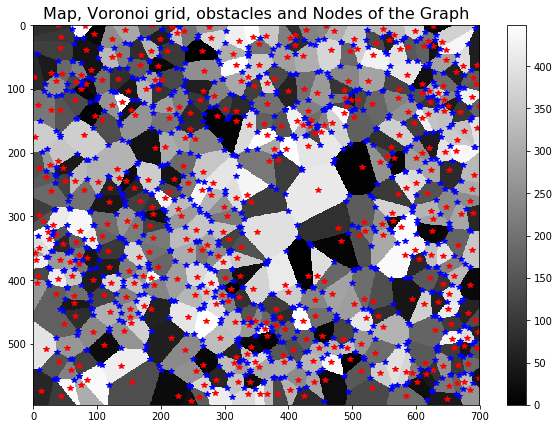

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(associationMap, cmap='gray')
plt.title('Map, Voronoi grid, obstacles and Nodes of the Graph', fontsize=16)
for index, (i, j) in enumerate(points):
    plt.plot(j, i, '*r')    

for (i, j), classes in nodes:
    plt.plot(j,i, '*b')
plt.colorbar(shrink=0.7)
plt.savefig('mapVoronoiObstaclesAndGraph.png')
plt.show()

### Get the paths and nodes from association map

In [11]:
paths = np.zeros(associationMap.shape)
pathsData = {}
nodes = {}
for i in range(associationMap.shape[0]):
    for j in range(associationMap.shape[1]):
        classes = set([associationMap[i, j]])
        for ii, jj in getNeighbors(i, j):
            classes.add(associationMap[ii, jj])

        # If we are next to classes then it is a boundary or corner ...
        if len(classes) > 1:
            paths[i, j] = 1
            pathsData[(i, j)] = list(classes).copy()
        # For corners ...
        if len(classes) > 2:
            nodes[(i, j)] = list(classes).copy().copy()            

### Graph handeling

In [12]:
G = nx.Graph()
for node1, classes1 in nodes.items():
    for node2, classes2 in nodes.items():
        if node1 != node2 and len(np.intersect1d(classes1, classes2)) >= 2:
                G.add_edge(node1, node2)

In [13]:
print('Nombre de noeud : ', len(G.nodes()))
print('Nombre de arretes : ', len(G.edges()))

Nombre de noeud :  814
Nombre de arretes :  1187


### Visualization

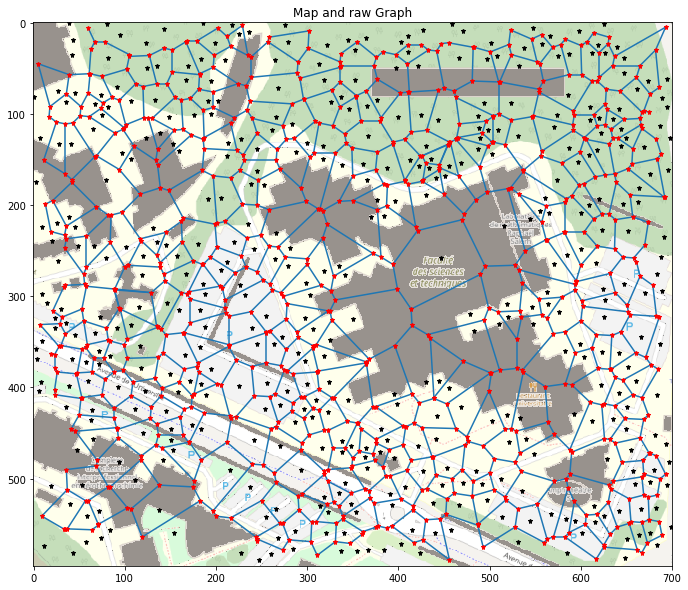

In [14]:
fig = plt.figure(figsize=(15,10))
plt.title('Map and raw Graph')

plt.imshow(img_)
for i, j in points:
    plt.plot(j, i, "k*", markersize=5)

plt.imshow(1 - myMap, cmap='gray', alpha=0.3)
ax = plt.gca()
for edge in G.edges:
    line = Line2D([edge[0][1], edge[1][1]], [edge[0][0], edge[1][0]])
    ax.add_line(line)
for pos in nodes.keys():
    plt.plot(pos[1], pos[0], 'r*', markersize=5)
plt.savefig('mapAndGraph.png')
plt.show()